In [428]:
import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error

In [429]:
!pip install xgboost

In [430]:
import xgboost as xgb

In [431]:
# Load the closing prices 
file_path = Path('Data/df.csv')
df = pd.read_csv(file_path)
df = df.drop([1])
df.head()

,Attributes,Volume,Volume.1,Volume.2,Adj Close,Adj Close.1,Adj Close.2
0,Symbols,GSK,PFE,AZN,GSK,PFE,AZN
2,1/2/2018,9465500,16185800,6107400,32.10053253,32.92734146,31.99385643
3,1/3/2018,6600800,13456500,4195400,31.97884941,33.1713028,32.05715179
4,1/4/2018,5206400,12378100,3870900,32.03968811,33.24359894,32.1023674
5,1/5/2018,7250700,12492900,3336000,32.60468292,33.30685043,32.43695831


In [432]:
def construct_df(df, volume, adj_close):
    r_df = pd.DataFrame({"Volume": df[volume], "Adj Close": df[adj_close], 
                      "Date": df["Attributes"]})
    r_df.drop([0], inplace=True)
    r_df["Volume"] = r_df["Volume"].astype(float)
    r_df["Adj Close"] = r_df["Adj Close"].astype(float)
    r_df["Date"] = pd.to_datetime(r_df["Date"])
    r_df.drop(r_df.loc[r_df["Date"] <'2020-01-01'].index, inplace=True)
    r_df = r_df.set_index("Date")
    return r_df
    

In [433]:
# extract data for GSk and create a dataframe for GSk
gsk_df = construct_df(df, "Volume","Adj Close")
gsk_df.head()

,Volume,Adj Close
Date,,
2020-01-02,2462400.0,45.229774
2020-01-03,2149100.0,44.805626
2020-01-06,2034500.0,44.824902
2020-01-07,1718900.0,44.545349
2020-01-08,1766700.0,44.738148


In [434]:
# extract data for PFE and create a dataframe for PFE
pfe_df = construct_df(df, "Volume.1","Adj Close.1")
pfe_df.head()

,Volume,Adj Close
Date,,
2020-01-02,15668000.0,37.990608
2020-01-03,14158300.0,37.786774
2020-01-06,14963900.0,37.738239
2020-01-07,19077900.0,37.612064
2020-01-08,15563100.0,37.912960


In [435]:
# extract data for AZN and create a dataframe for AZN
azn_df = construct_df(df, "Volume.2","Adj Close.2")
azn_df.head()

,Volume,Adj Close
Date,,
2020-01-02,3587300.0,48.992023
2020-01-03,1208700.0,48.700348
2020-01-06,1992300.0,48.496174
2020-01-07,1871900.0,48.680901
2020-01-08,1869000.0,48.564232


In [437]:
window = 3
i = 183

data = azn_df[['Volume', 'Adj Close']].shift(window).iloc[i:,:].iloc[:window]
data_index = azn_df.iloc[i - window:i,:].index
data.set_index(data_index, inplace=True)
data.head()

,Volume,Adj Close
Date,,
2020-09-18,2931700.0,56.450001
2020-09-21,6792700.0,55.910000
2020-09-22,3878600.0,55.439999


In [438]:
data.T

Date,2020-09-18,2020-09-21,2020-09-22
Volume,2.931700e+06,6792700.00,3.878600e+06
Adj Close,5.645000e+01,55.91,5.544000e+01


In [442]:
window = 3
columns = []
for i in range(window):
    volume_col = 'Volume-' + str(i)
    columns.append(volume_col)
    close_col = 'Adj Close-' + str(i)
    columns.append(close_col)
    
rr = pd.DataFrame(columns=columns)

for i in range(window):
    volume_col = 'Volume-' + str(i)
    rr[volume_col] = [data.T.iloc[0,i]]
    columns.append(volume_col)
    close_col = 'Adj Close-' + str(i)
    rr[close_col] = [data.T.iloc[1,i]]
    columns.append(close_col)

rr.head()

,Volume-0,Adj Close-0,Volume-1,Adj Close-1,Volume-2,Adj Close-2
0,2931700.0,56.450001,6792700.0,55.91,3878600.0,55.439999


In [443]:
azn_df.iloc[i:i+1,:].index[0]

Timestamp('2020-01-06 00:00:00')

In [444]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y

# assumption: df index is sorted

def generate_column_names(window):
    
    columns = []
    for i in range(window):
        volume_col = 'Volume-' + str(i)
        columns.append(volume_col)
        close_col = 'Adj Close-' + str(i)
        columns.append(close_col)
        
    columns.append('Close')
    columns.append('Date')
    return columns


def generate_column_containers(window):
    
    columns = {}
    for i in range(window):
        volume_col = 'Volume-' + str(i)
        columns[volume_col] = []
        close_col = 'Adj Close-' + str(i)
        columns[close_col] = []
        
    columns['Close'] = []
    columns['Date'] = []
    return columns

def window_data(df, window):
    
    column_data = generate_column_containers(window)
    column_names = generate_column_names(window)
    
    for i in range(window, len(df) - window):

        # data should start from history before index and has the size of window 
        data = df[['Volume', 'Adj Close']].shift(window).iloc[i:,:].iloc[:window]
        data_index = df.iloc[i - window:i,:].index
        data.set_index(data_index, inplace=True)
        
        # update indices
        column_data["Date"].append(df.iloc[i:i+1,:].index[0])
        column_data["Close"].append(df.iloc[i+1,1])
        
        # update column_data based on column names
        for j in range(window):
            volume_col = 'Volume-' + str(j)
            column_data[volume_col].append(data.T.iloc[0,j])
            close_col = 'Adj Close-' + str(j)
            column_data[close_col].append(data.T.iloc[1,j])
    
    r_df = pd.DataFrame(column_data, columns = column_names)
    r_df.set_index("Date", inplace=True)
    return r_df

In [445]:
window = 5

In [446]:
gsk_d_df = window_data(gsk_df, window)
gsk_d_df.head()

,Volume-0,Adj Close-0,Volume-1,Adj Close-1,Volume-2,Adj Close-2,Volume-3,Adj Close-3,Volume-4,Adj Close-4,Close
Date,,,,,,,,,,,
2020-01-09,2462400.0,45.229774,2149100.0,44.805626,2034500.0,44.824902,1718900.0,44.545349,1766700.0,44.738148,45.104458
2020-01-10,2149100.0,44.805626,2034500.0,44.824902,1718900.0,44.545349,1766700.0,44.738148,2169400.0,44.969505,45.258698
2020-01-13,2034500.0,44.824902,1718900.0,44.545349,1766700.0,44.738148,2169400.0,44.969505,1933300.0,45.104458,45.345451
2020-01-14,1718900.0,44.545349,1766700.0,44.738148,2169400.0,44.969505,1933300.0,45.104458,1858000.0,45.258698,45.894920
2020-01-15,1766700.0,44.738148,2169400.0,44.969505,1933300.0,45.104458,1858000.0,45.258698,1767700.0,45.345451,45.461132


In [447]:
# Generate data for training and testing out of pfe_df
pfe_d_df = window_data(pfe_df, window)
pfe_d_df.head()

,Volume-0,Adj Close-0,Volume-1,Adj Close-1,Volume-2,Adj Close-2,Volume-3,Adj Close-3,Volume-4,Adj Close-4,Close
Date,,,,,,,,,,,
2020-01-09,15668000.0,37.990608,14158300.0,37.786774,14963900.0,37.738239,19077900.0,37.612064,15563100.0,37.912960,38.330326
2020-01-10,14158300.0,37.786774,14963900.0,37.738239,19077900.0,37.612064,15563100.0,37.912960,20846200.0,37.747952,38.252674
2020-01-13,14963900.0,37.738239,19077900.0,37.612064,15563100.0,37.912960,20846200.0,37.747952,20452900.0,38.330326,38.893295
2020-01-14,19077900.0,37.612064,15563100.0,37.912960,20846200.0,37.747952,20452900.0,38.330326,14603800.0,38.252674,39.475674
2020-01-15,15563100.0,37.912960,20846200.0,37.747952,20452900.0,38.330326,14603800.0,38.252674,19847400.0,38.893295,39.417439


In [448]:
# Generate data for training and testing out of azn_df
azn_d_df = window_data(azn_df, window)
azn_d_df.head()

,Volume-0,Adj Close-0,Volume-1,Adj Close-1,Volume-2,Adj Close-2,Volume-3,Adj Close-3,Volume-4,Adj Close-4,Close
Date,,,,,,,,,,,
2020-01-09,3587300.0,48.992023,1208700.0,48.700348,1992300.0,48.496174,1871900.0,48.680901,1869000.0,48.564232,48.467003
2020-01-10,1208700.0,48.700348,1992300.0,48.496174,1871900.0,48.680901,1869000.0,48.564232,1959000.0,48.690624,48.291996
2020-01-13,1992300.0,48.496174,1871900.0,48.680901,1869000.0,48.564232,1959000.0,48.690624,1872900.0,48.467003,48.787849
2020-01-14,1871900.0,48.680901,1869000.0,48.564232,1959000.0,48.690624,1872900.0,48.467003,2395900.0,48.291996,49.390644
2020-01-15,1869000.0,48.564232,1959000.0,48.690624,1872900.0,48.467003,2395900.0,48.291996,2230800.0,48.787849,49.108692


In [449]:
def train_test_data_split(df):
   
    # Use 80% of the data for training and the remainder for testing
    split = int(0.8 * len(df))
    train_d = df.iloc[:split]
    test_d = df.iloc[split:]
    print(f"train data shape: {train_d.shape}")
    print(f"test data shape: {test_d.shape}")
    print(f"df shape: {df.shape}")
    
    return train_d, test_d

In [450]:
# generate both training data set and testing data set using GSK data 
gsk_train, gsk_test = train_test_data_split(gsk_d_df)

# generate both training data set and testing data set using PFE data 
pfe_train, pfe_test = train_test_data_split(pfe_d_df)

# generate both training data set and testing data set using AZN data 
azn_train, azn_test = train_test_data_split(azn_d_df)

train data shape: (140, 11)
test data shape: (36, 11)
df shape: (176, 11)
train data shape: (140, 11)
test data shape: (36, 11)
df shape: (176, 11)
train data shape: (140, 11)
test data shape: (36, 11)
df shape: (176, 11)


In [451]:
# split X_train and y_train for GSK training data
gsk_X_train, gsk_y_train = gsk_train.iloc[:,:-1], gsk_train.iloc[:,-1]

# split X_test and y_test for GSK test data
gsk_X_test, gsk_y_test = gsk_test.iloc[:,:-1], gsk_test.iloc[:,-1]

# split X_train and y_train for PFE training data
pfe_X_train, pfe_y_train = pfe_train.iloc[:,:-1], pfe_train.iloc[:,-1]

# split X_test and y_test for PFE test data
pfe_X_test, pfe_y_test = pfe_test.iloc[:,:-1], pfe_test.iloc[:,-1]

# split X_train and y_train for AZN training data
azn_X_train, azn_y_train = azn_train.iloc[:,:-1], azn_train.iloc[:,-1]

# split X_test and y_test for AZN test data
azn_X_test, azn_y_test = azn_test.iloc[:,:-1], azn_test.iloc[:,-1]

In [453]:
def xgboost_forecast(train_X, train_y, test_X):
    # create XGBoost regressor
    model = xgb.XGBRegressor(
        objective='reg:squarederror', 
        n_estimators=1000, 
        learning_rate=0.05
    )

    # fir the model using GSK train data
    model.fit(
        train_X, 
        train_y, 
        eval_metric="rmse", 
        verbose=True
    )

    # make a prediction
    pred_y = model.predict(test_X)
    return pred_y

In [454]:
def eval_perf(df, y_pred, y_test, source):
    
    # print mean absolute score
    mae = mean_absolute_error(y_test.values, y_pred)
    print('MAE: %.3f' % mae)

    split = int(0.8 * len(df))

    # Create a DataFrame of Real and Predicted values
    perf = pd.DataFrame({
        "Real": y_test.values,
        "Predicted": y_pred
    }, index = df.index[split: ])  

    # Plot the real vs predicted values as a line chart
    perf.plot(figsize=(8,6), title=f"XGBoost Performance Visualization on {source}")

MAE: 0.650


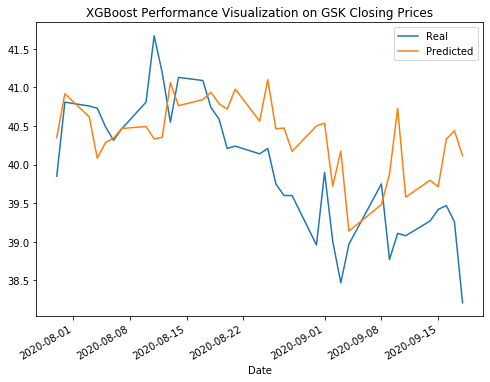

In [455]:
# Perform XGBoost forcecasting on GSK Closing prices
gsk_y_pred = xgboost_forecast(gsk_X_train, gsk_y_train, gsk_X_test)
eval_perf(gsk_d_df, gsk_y_pred, gsk_y_test, "GSK Closing Prices")

MAE: 0.760


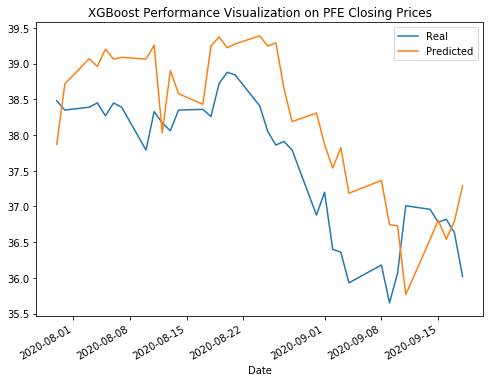

In [456]:
# Perform XGBoost forcecasting on PFE Closing prices
pfe_y_pred = xgboost_forecast(pfe_X_train, pfe_y_train, pfe_X_test)
eval_perf(pfe_d_df, pfe_y_pred, pfe_y_test, "PFE Closing Prices")

MAE: 1.099


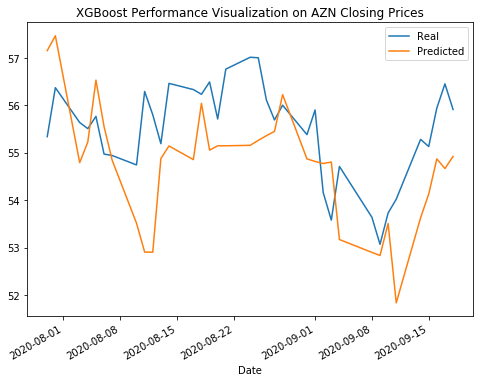

In [457]:
# Perform XGBoost forcecasting on AZN Closing prices
azn_y_pred = xgboost_forecast(azn_X_train, azn_y_train, azn_X_test)
eval_perf(azn_d_df, azn_y_pred, azn_y_test, "AZN Closing Prices")